In [1]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

In [2]:
dir.create("backup/b12/") #visual/

outputRoot=paste0( getwd(), "/backup/b12/") 
outputRoot

[1] "/data/wangjl/scScripts/backup/b12/"

In [4]:
##
library(Seurat)
library(monocle)

library(tidyverse)
library(patchwork)

https://bioconductor.org/packages/release/bioc/vignettes/slingshot/inst/doc/vignette.html

# 简介

## 模拟数据

In [10]:
library(SingleCellExperiment)

In [16]:
# generate synthetic count data representing a single lineage
set.seed(20210218)
means <- rbind(
    # non-DE genes
    matrix(rep(rep(c(0.1,0.5,1,2,3), each = 300),100),
        ncol = 300, byrow = TRUE),
    # early deactivation
    matrix(rep(exp(atan( ((300:1)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # late deactivation
    matrix(rep(exp(atan( ((300:1)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # early activation
    matrix(rep(exp(atan( ((1:300)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # late activation
    matrix(rep(exp(atan( ((1:300)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # transient
    matrix(rep(exp(atan( c((1:100)/33, rep(3,100), (100:1)/33) )),50), 
        ncol = 300, byrow = TRUE)
)
counts <- apply(means,2,function(cell_means){
    total <- rnbinom(1, mu = 7500, size = 4)
    rmultinom(1, total, cell_means)
})

rownames(counts) <- paste0('G',1:750)
colnames(counts) <- paste0('c',1:300)

# 构建一个sce对象
sim <- SingleCellExperiment(assays = List(counts = counts))
sim

class: SingleCellExperiment 
dim: 750 300 
metadata(0):
assays(1): counts
rownames(750): G1 G2 ... G749 G750
rowData names(0):
colnames(300): c1 c2 ... c299 c300
colData names(0):
reducedDimNames(0):
spikeNames(0):

In [17]:
dim(counts)
counts[1:3,1:5]

[1] 750 300

,c1,c2,c3,c4,c5
G1,0,0,0,0,1
G2,2,1,2,0,0
G3,7,3,7,0,4


In [22]:
# str(sim)

## 基因过滤

In [20]:
geneFilter <- apply( assays(sim)$counts, 1, function(x){
    sum(x >= 3) >= 10
})
sim <- sim[geneFilter, ]
sim

class: SingleCellExperiment 
dim: 727 300 
metadata(0):
assays(1): counts
rownames(727): G1 G2 ... G749 G750
rowData names(0):
colnames(300): c1 c2 ... c299 c300
colData names(0):
reducedDimNames(0):
spikeNames(0):

In [21]:
# 过滤掉n个基因:  750-727=23
dim(sim)

[1] 727 300

## 归一化 Normalization

In [23]:
# Hence, we will proceed with full quantile normalization, 
# a well-established method which forces each cell to have the same distribution of expression values.
FQnorm <- function(counts){
    rk <- apply(counts,2, rank, ties.method='min') #每列的排序编号
    
    counts.sort <- apply(counts,2,sort)  #每列排序
    refdist <- apply(counts.sort,1,median) #每行求中位数
    
    norm <- apply(rk, 2, function(r){ refdist[r] }) #每行
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sim)$norm <- FQnorm(assays(sim)$counts)

## 降维

### 方法一：PCA

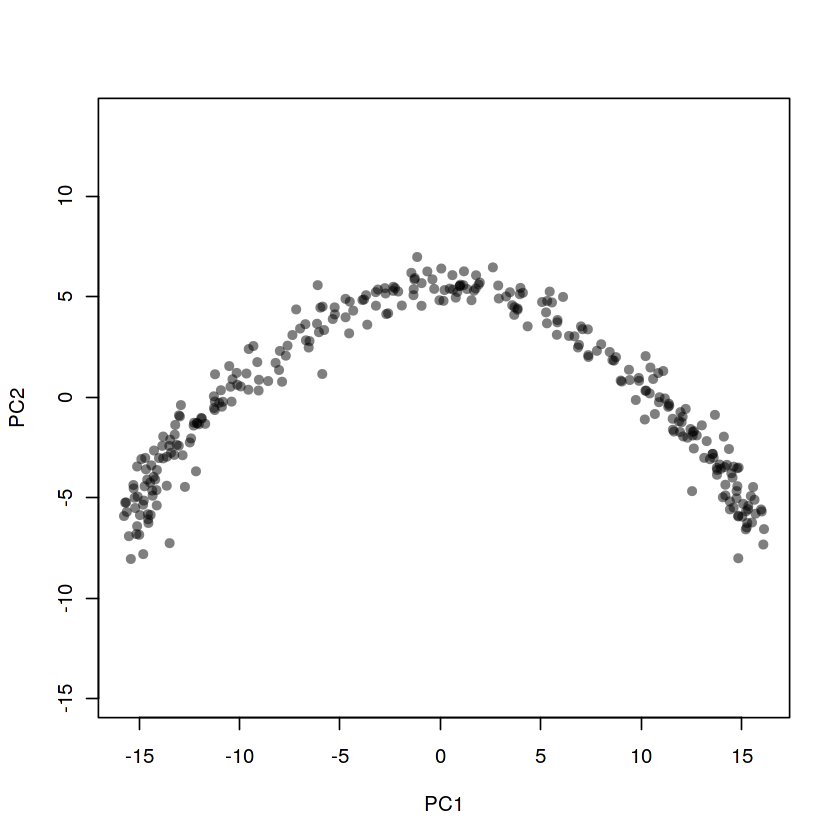

In [24]:
pca <- prcomp( t(  log1p(assays(sim)$norm  )), scale. = FALSE )
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

### 方法二：diffusion maps

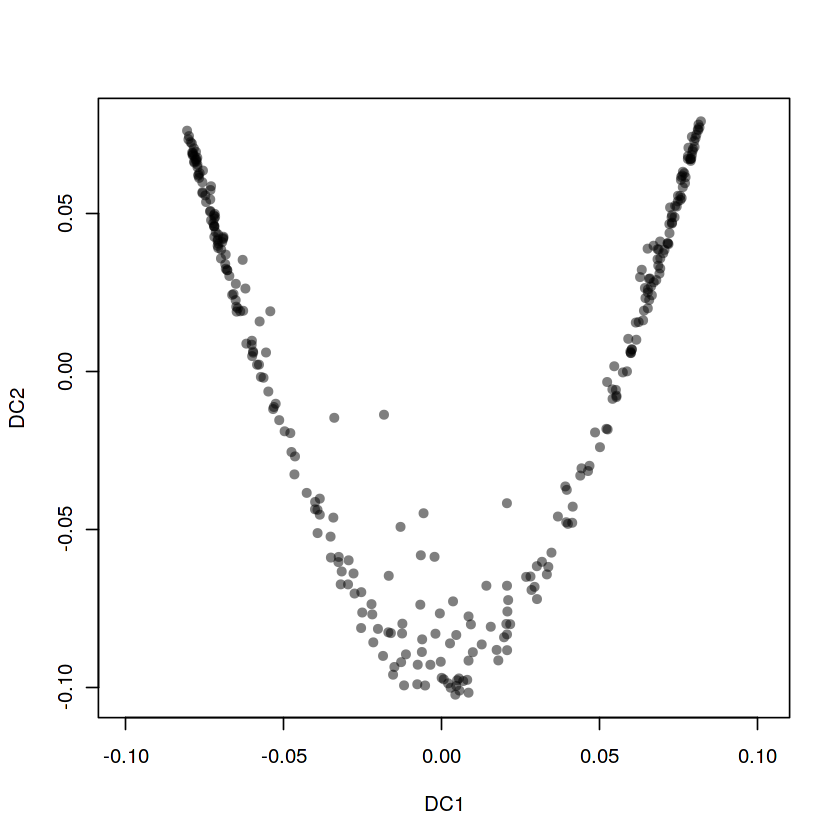

In [26]:
library(destiny, quietly = TRUE)

dm <- DiffusionMap( t(log1p(assays(sim)$norm)) )
rd2 <- cbind(DC1 = dm$DC1, DC2 = dm$DC2)
plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

### 方法3: UMAP

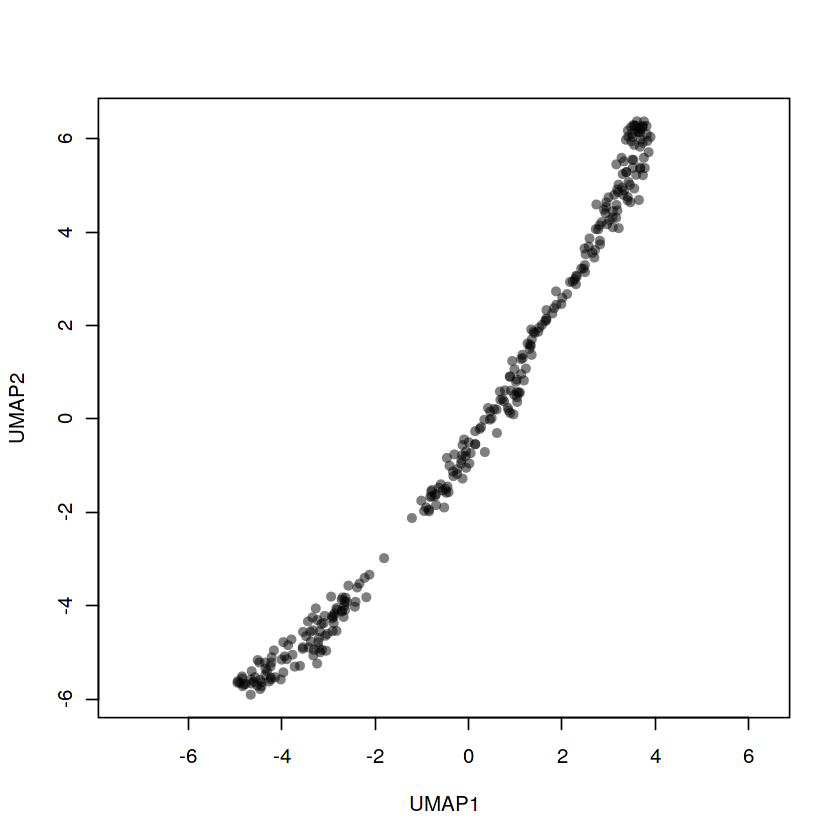

In [35]:
library(uwot)

rd3 <- umap(t(log1p(assays(sim)$norm)))
colnames(rd3) <- c('UMAP1', 'UMAP2')

plot(rd3, col = rgb(0,0,0,.5), pch=16, asp = 1)

### 保存结果

In [36]:
reducedDims(sim) <- SimpleList(PCA = rd1, DiffMap = rd2, UMAP = rd3)

## 聚类 Clustering Cells

### 方法一：Gaussian mixture modeling

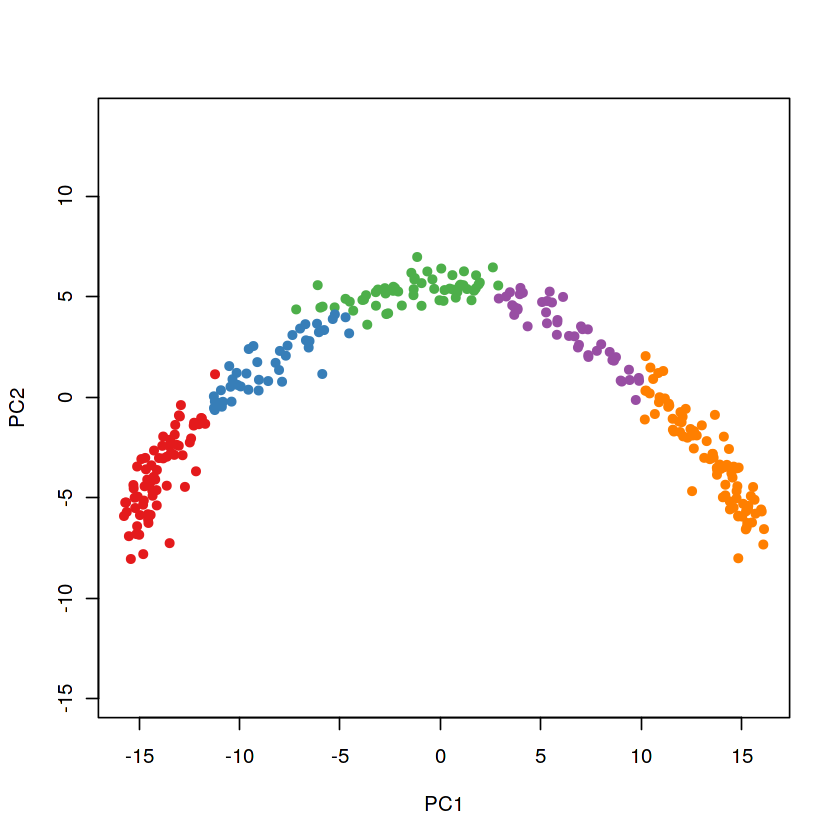

In [42]:
library(mclust, quietly = TRUE)

#根据PCA结果
cl1 <- Mclust(rd1)$classification
colData(sim)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

In [56]:
head(cl1)
table(cl1)

c1 c2 c3 c4 c5 c6 
 1  1  1  1  1  1

cl1
 1  2  3  4  5 
70 43 58 44 85 

#### 根据UMAP结果

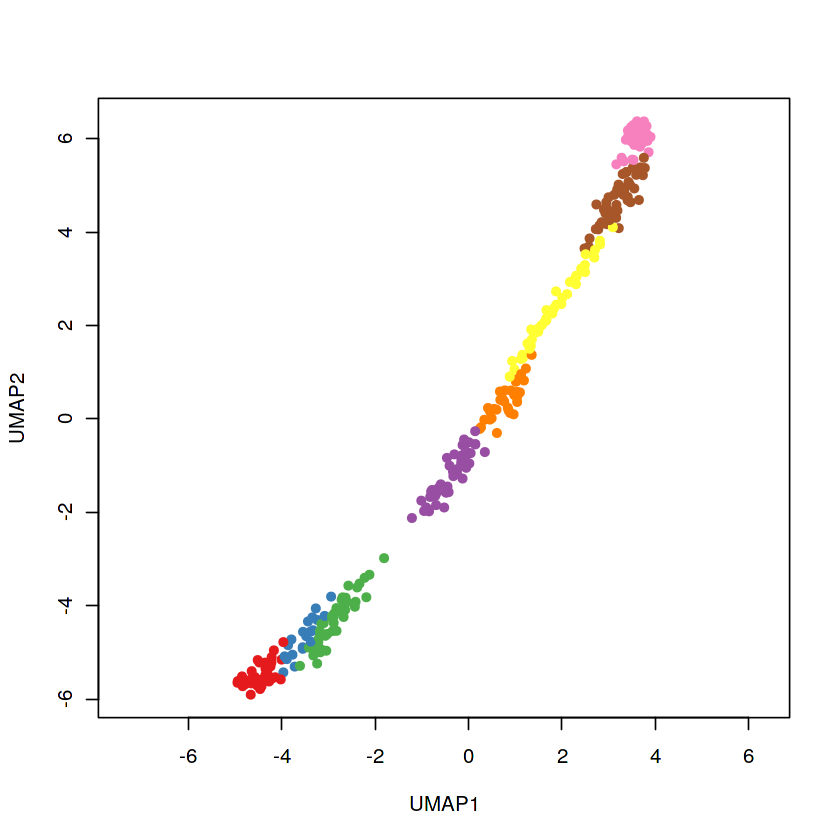

In [37]:
##根据UMAP结果
cl13 <- Mclust(rd3)$classification
colData(sim)$GMM <- cl13

library(RColorBrewer)
plot(rd3, col = brewer.pal(9,"Set1")[cl13], pch=16, asp = 1)

### 方法二：k-means

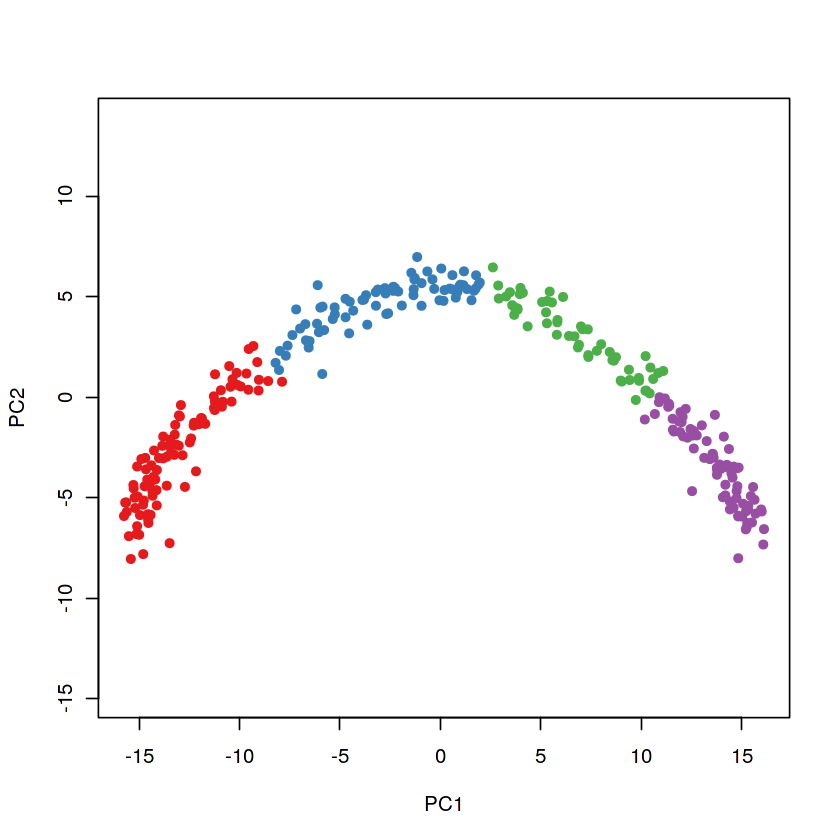

In [29]:
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sim)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

## 使用slingshot

### 基于PCA

In [44]:
sim <- slingshot(sim, clusterLabels = 'GMM', reducedDim = 'PCA')
summary(sim$slingPseudotime_1)
##    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
##   0.000   8.633  21.118  21.415  34.367  43.186

Using full covariance matrix



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   9.091  21.730  21.618  34.226  43.029 

In [509]:
head(sim$slingPseudotime_1)

[1] 1.2360693 0.5445672 1.5923820 0.0000000 1.7322026 1.5336650

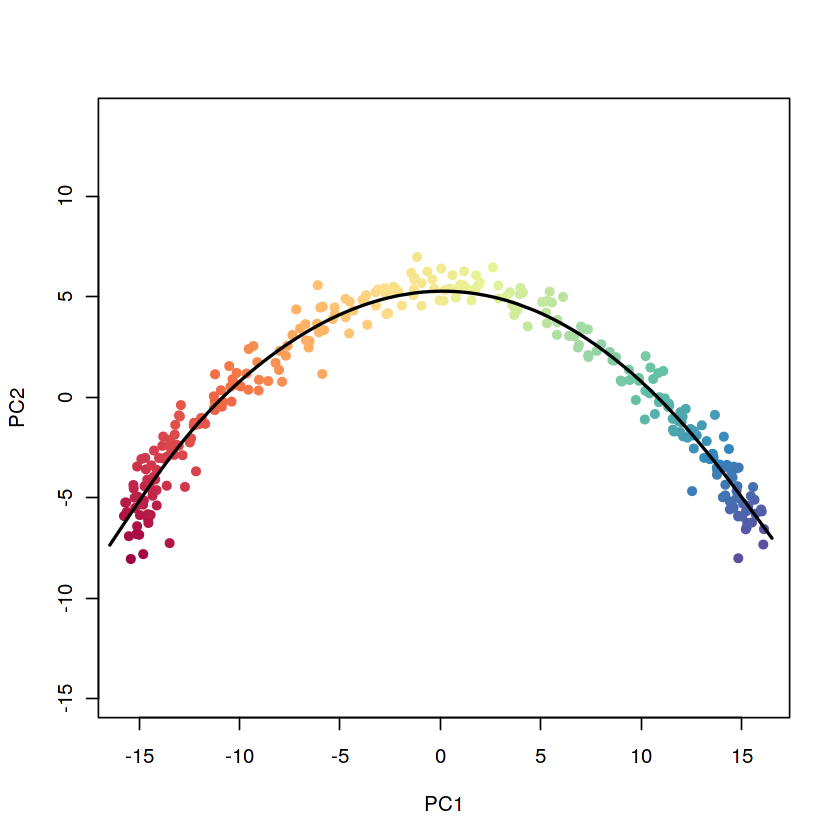

In [45]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100) #产生100个连续的颜色
plotcol <- colors[cut(sim$slingPseudotime_1, breaks=100)]

plot(reducedDims(sim)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, col='black')

We can also see how the lineage structure was intially estimated by the cluster-based minimum spanning tree by using the type argument.

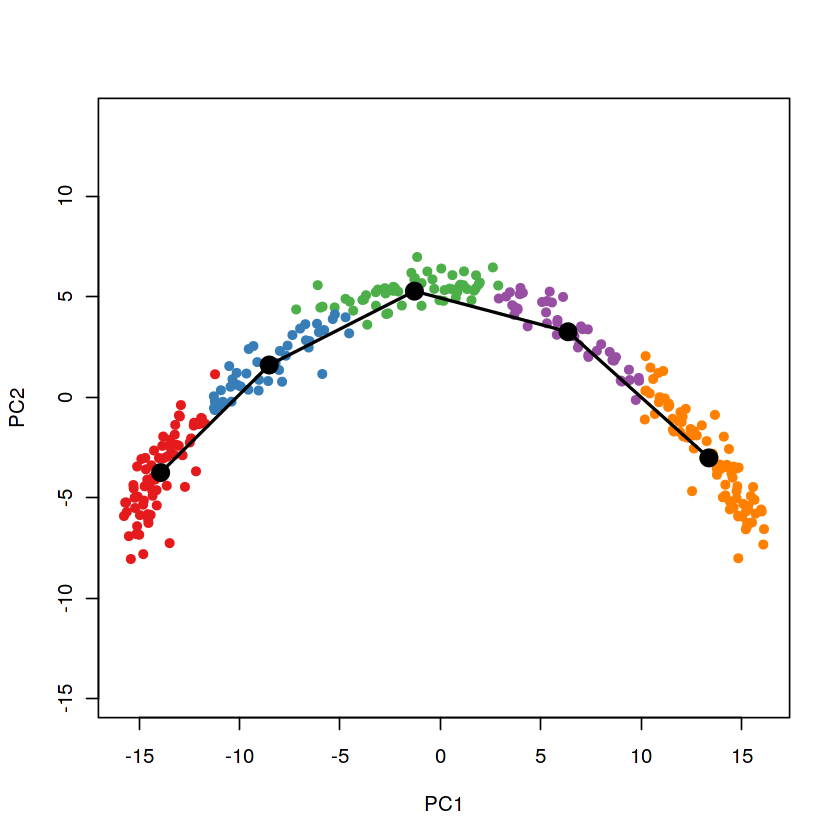

In [46]:
# 添加点
plot(reducedDims(sim)$PCA, col = brewer.pal(9,'Set1')[sim$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, 
      type = 'lineages', 
      col = 'black')

### 基于UMAP

In [47]:
sim <- slingshot(sim, clusterLabels = 'GMM', reducedDim = 'UMAP')
summary(sim$slingPseudotime_1)
##    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
##   0.000   8.633  21.118  21.415  34.367  43.186

Using full covariance matrix



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   9.091  21.730  21.618  34.226  43.029 

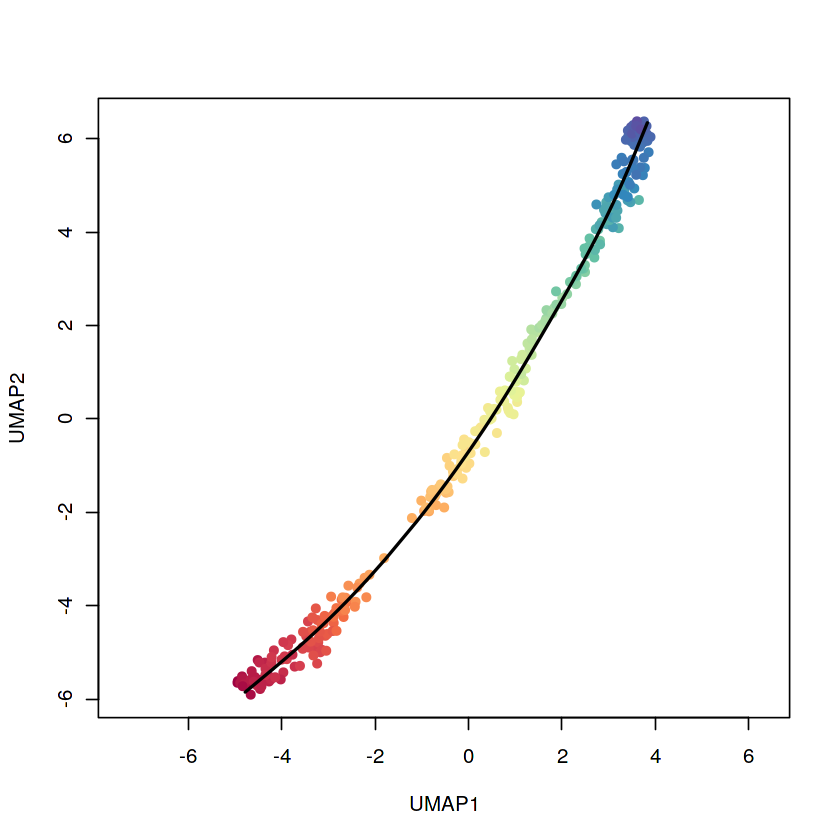

In [48]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100) #产生100个连续的颜色
plotcol <- colors[cut(sim$slingPseudotime_1, breaks=100)]

plot(reducedDims(sim)$UMAP, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, col='black')

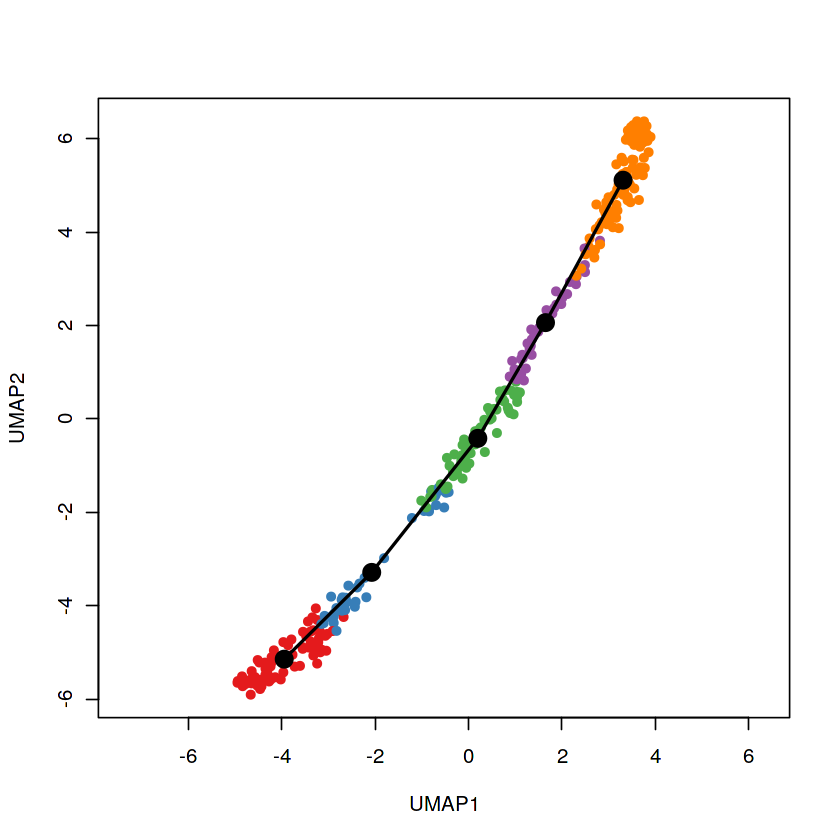

In [49]:
plot(reducedDims(sim)$UMAP, col = brewer.pal(9,'Set1')[sim$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, 
      type = 'lineages', 
      col = 'black')

## Downstream Analysis

After running slingshot, an interesting next step may be to find genes that change their expression over the course of development. We will demonstrate this type of analysis using the tradeSeq package (Van den Berge et al. 2020).

For each gene, we will fit a general additive model (GAM) using a negative binomial noise distribution to model the (potentially nonlinear) relationshipships between gene expression and pseudotime. We will then test for significant associations between expression and pseudotime using the **associationTest**.

In [ ]:
library(tradeSeq) # Error: package ‘tradeSeq’ is not available (for R version 3.6.3) 

# fit negative binomial GAM
sim <- fitGAM(sim)

# test for dynamic expression
ATres <- associationTest(sim)

In [ ]:
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:250]
pst.ord <- order(sim$slingPseudotime_1, na.last = NA)
heatdata <- assays(sim)$counts[topgenes, pst.ord]
heatclus <- sim$GMM[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])

## Detailed Slingshot Functionality

### Identifying global lineage structure

In [51]:
head(rd)

,dim-1,dim-2
cell-1,-4.437117,0.3690586
cell-2,-3.837149,-0.1009774
cell-3,-2.730936,-0.9770827
cell-4,-4.219531,-0.7100939
cell-5,-3.717672,-0.6452345
cell-6,-3.053360,-0.2838916


In [57]:
head(cl1)

c1 c2 c3 c4 c5 c6 
 1  1  1  1  1  1

In [62]:
lin1 <- getLineages(rd1, cl1, start.clus = '1')

Using full covariance matrix



In [63]:
lin1

class: SlingshotDataSet 

 Samples Dimensions
     300          2

lineages: 1 
Lineage1: 1  2  3  4  5  

curves: 0 

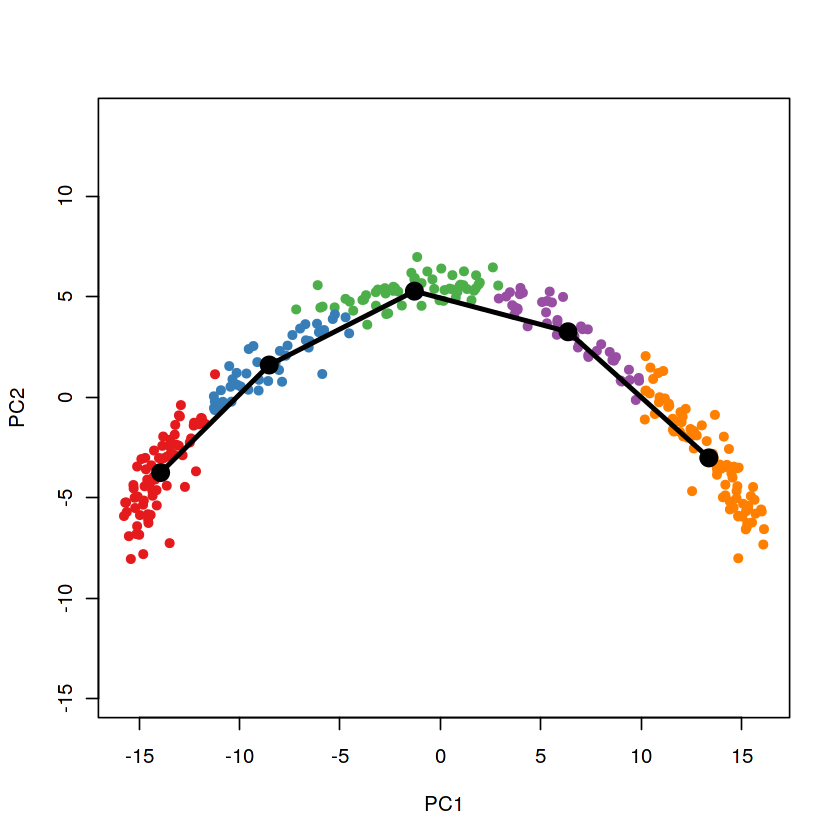

In [64]:
plot(rd1, col = brewer.pal(9,"Set1")[cl1], asp = 1, pch = 16)
lines(lin1, lwd = 3, col = 'black')

#### 指定起始

In [71]:
lin2 <- getLineages(rd1, cl1, start.clus= '1', end.clus = '3')

Using full covariance matrix



In [72]:
lin2
# 指定从1到3，则推出2条路径

class: SlingshotDataSet 

 Samples Dimensions
     300          2

lineages: 2 
Lineage1: 1  2  4  3  
Lineage2: 1  2  4  5  

curves: 0 

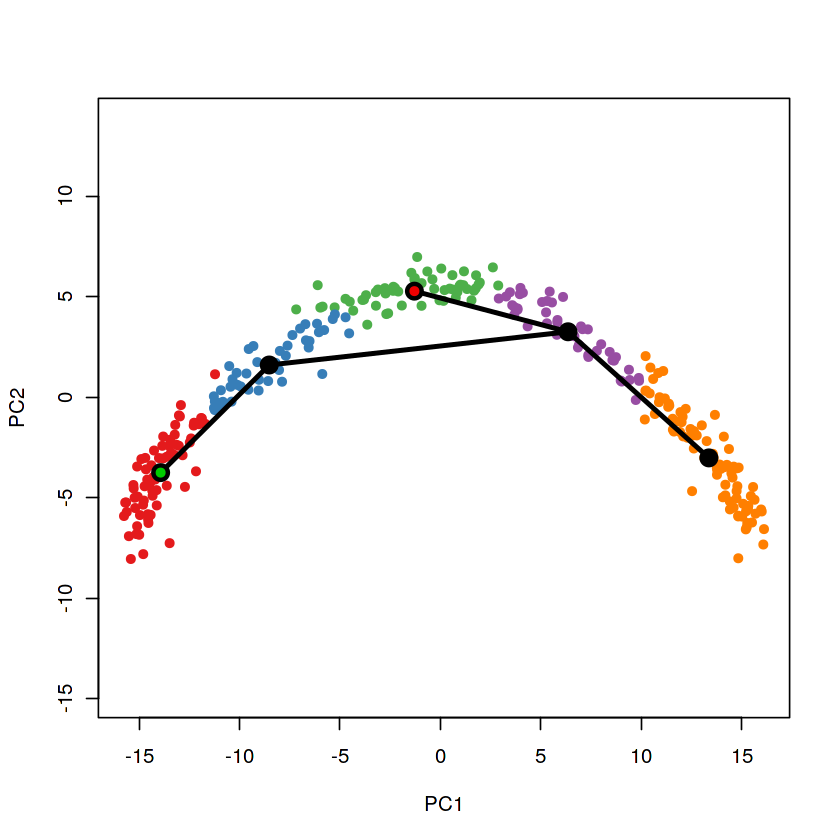

In [73]:
plot(rd1, col = brewer.pal(9,"Set1")[cl1], asp = 1, pch = 16)
lines(lin2, lwd = 3, col = 'black', show.constraints = TRUE)

### Constructing smooth curves and ordering cells

In [74]:
crv1 <- getCurves(lin1)
crv1

class: SlingshotDataSet 

 Samples Dimensions
     300          2

lineages: 1 
Lineage1: 1  2  3  4  5  

curves: 1 
Curve1: Length: 43.029	Samples: 300

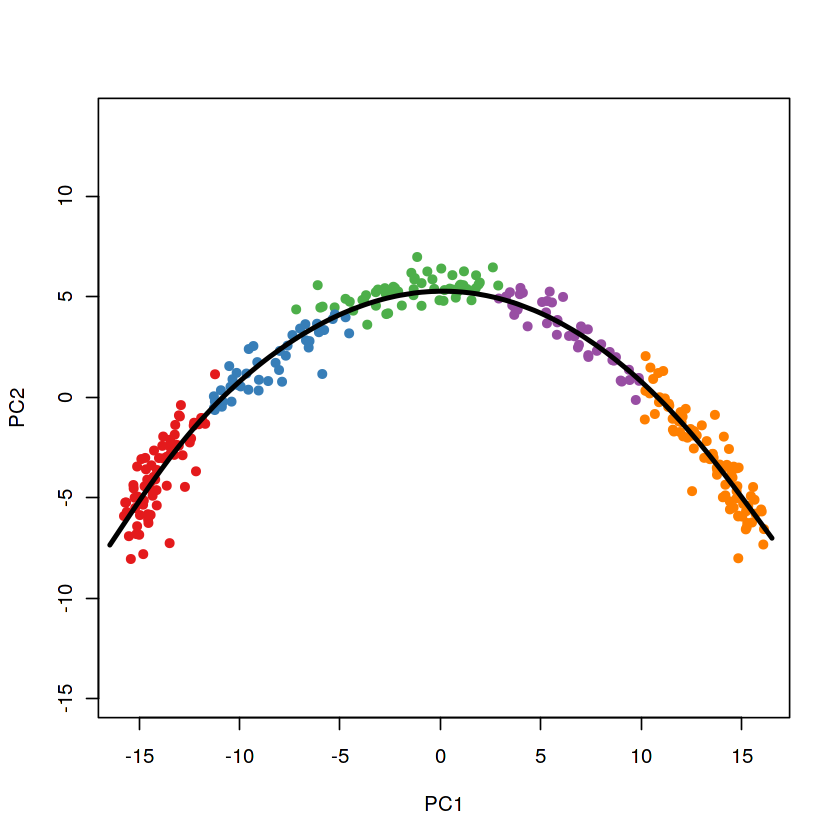

In [75]:
plot(rd1, col = brewer.pal(9,"Set1")[cl1], asp = 1, pch = 16)
lines(crv1, lwd = 3, col = 'black')

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


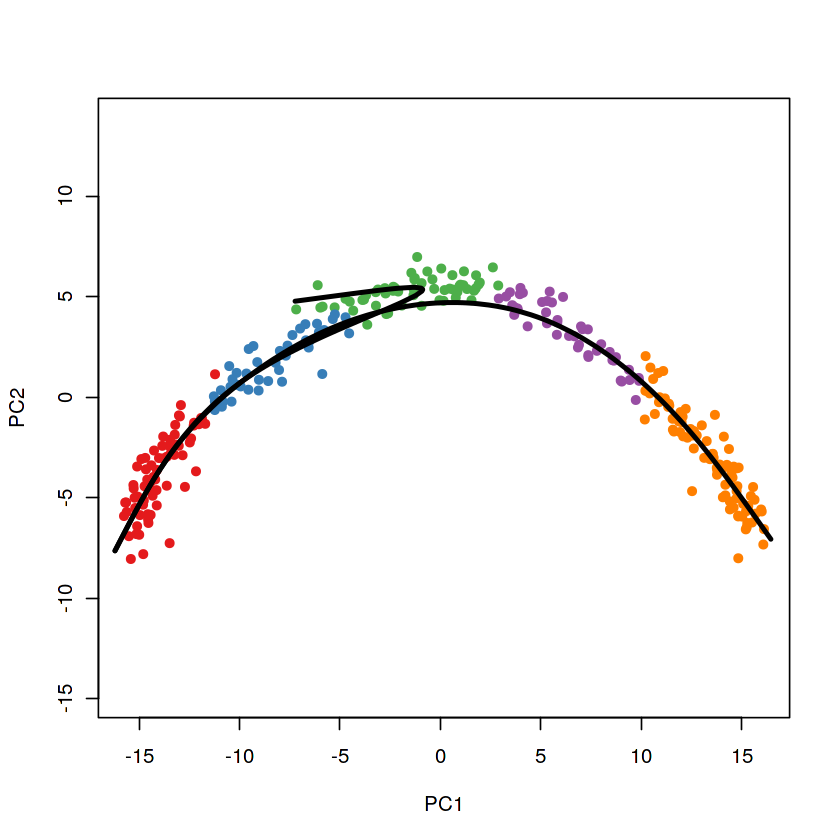

In [77]:
crv2 <- getCurves(lin2)

plot(rd1, col = brewer.pal(9,"Set1")[cl1], asp = 1, pch = 16)
lines(crv2, lwd = 3, col = 'black')

# 真实数据: Seurat pbmc

https://bustools.github.io/BUS_notebooks_R/slingshot.html

## 载入T细胞

In [482]:
sub_T <- readRDS("backup/a2/pbmc10k-Tsubset_final.rds")
sub_T

An object of class Seurat 
22860 features across 4624 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

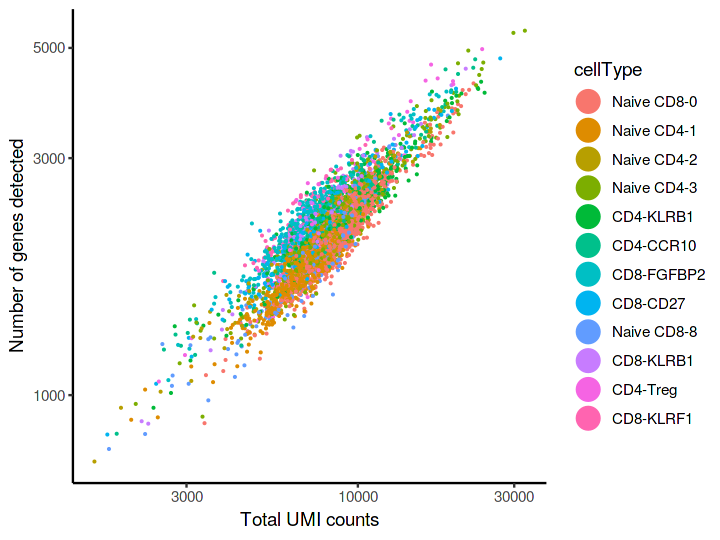

In [483]:
library(ggplot2)
g1=ggplot(sub_T@meta.data, aes(nCount_RNA, nFeature_RNA, color = cellType)) +
  geom_point(size = 0.1) +
  # scale_color_brewer( type = "qual", palette = "Set2",name = "cell type") + #Spectral
  # scale_color_manual( values =  c( brewer.pal(8,'Set2'), "black",'red','blue'), name = "cell type") +
  scale_x_log10() + scale_y_log10() +
  theme_classic()+ #theme_bw() +
  # Make points larger in legend
  guides(color = guide_legend(override.aes = list(size = 6))) +
  labs(x = "Total UMI counts", y = "Number of genes detected")

options(repr.plot.width=6, repr.plot.height=4.5)
g1

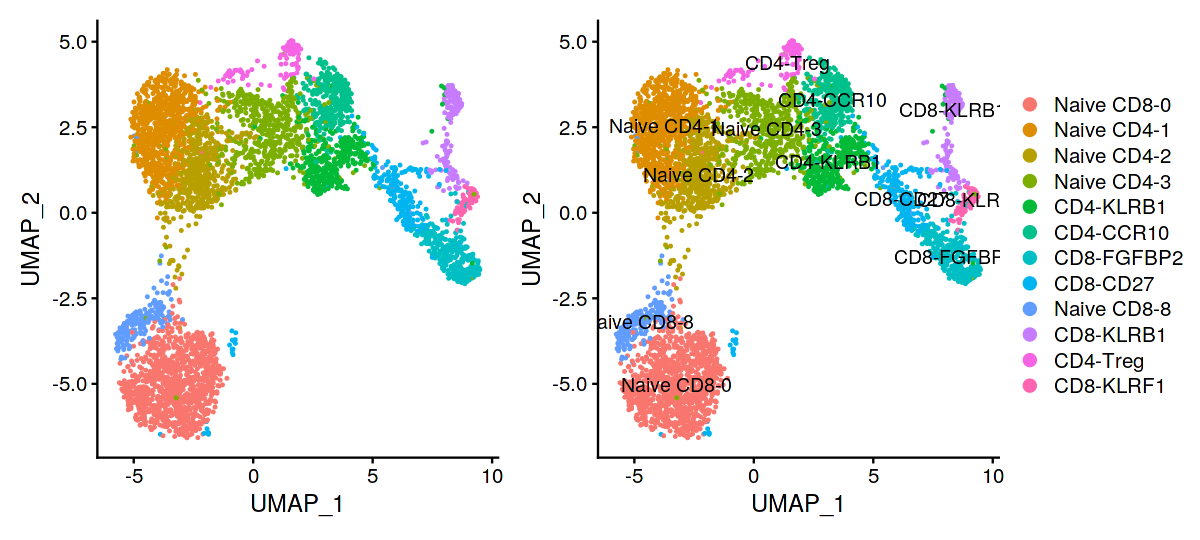

In [484]:
p0=DimPlot(sub_T, reduction = 'umap')
p1=DimPlot(sub_T, reduction = 'umap', label = T)

options(repr.plot.width=10, repr.plot.height=4.5)
p0+p1+ plot_layout(guides = 'collect')

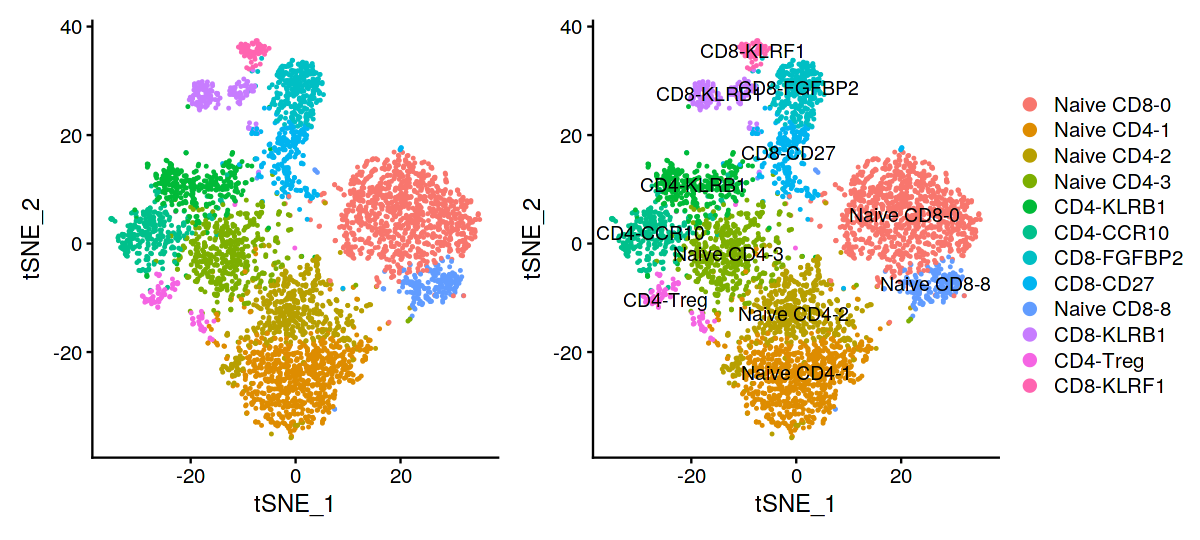

In [486]:
p0=DimPlot(sub_T, reduction = 'tsne')
p1=DimPlot(sub_T, reduction = 'tsne', label = T)

options(repr.plot.width=10, repr.plot.height=4.5)
p0+p1+ plot_layout(guides = 'collect')

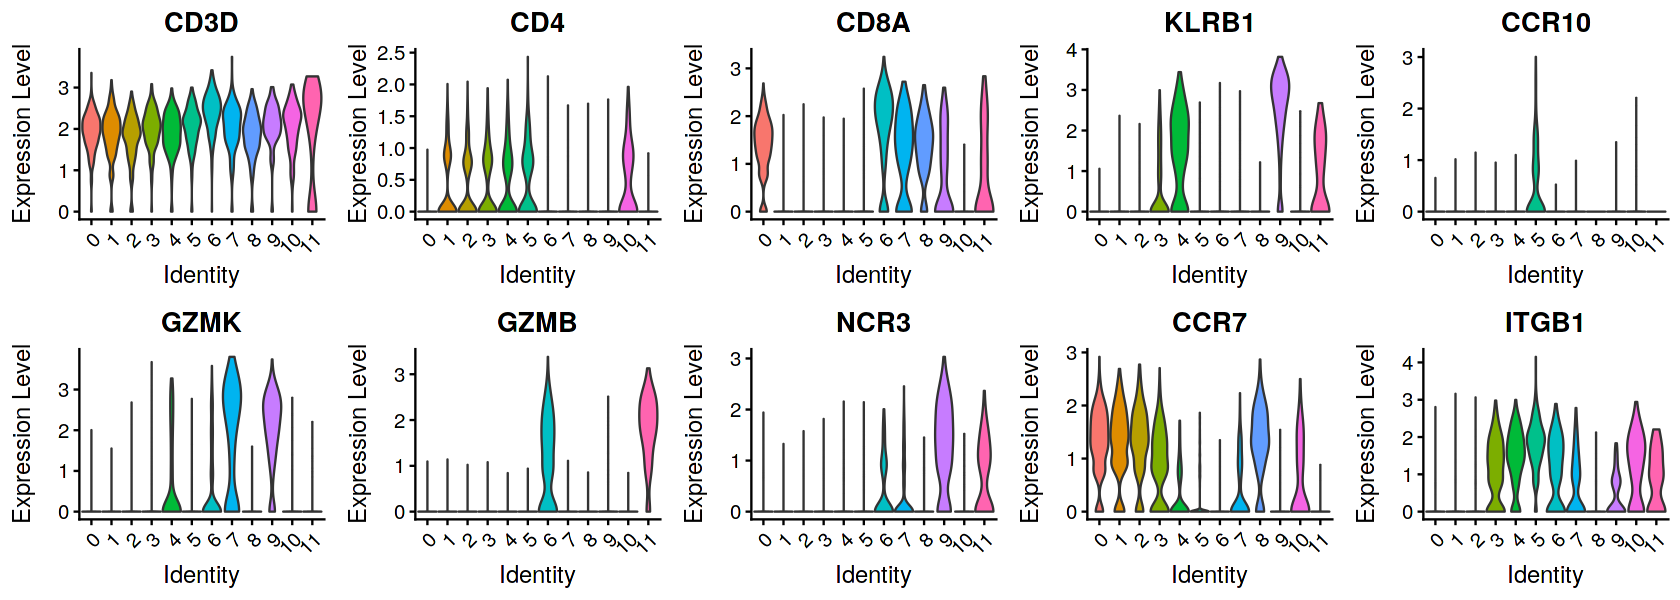

In [489]:
options(repr.plot.width=14, repr.plot.height=5)
VlnPlot(sub_T, features = c("CD3D","CD4", "CD8A", "KLRB1","CCR10", "GZMK", "GZMB","NCR3", "CCR7","ITGB1"), 
        ncol = 5, pt.size=0, group.by = "seurat_clusters")

In [490]:
Idents(sub_T)="seurat_clusters"
sub_T
table(sub_T@active.ident)

An object of class Seurat 
22860 features across 4624 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne


   0    1    2    3    4    5    6    7    8    9   10   11 
1052  784  544  501  347  304  304  233  196  174  103   82 

### dot plot

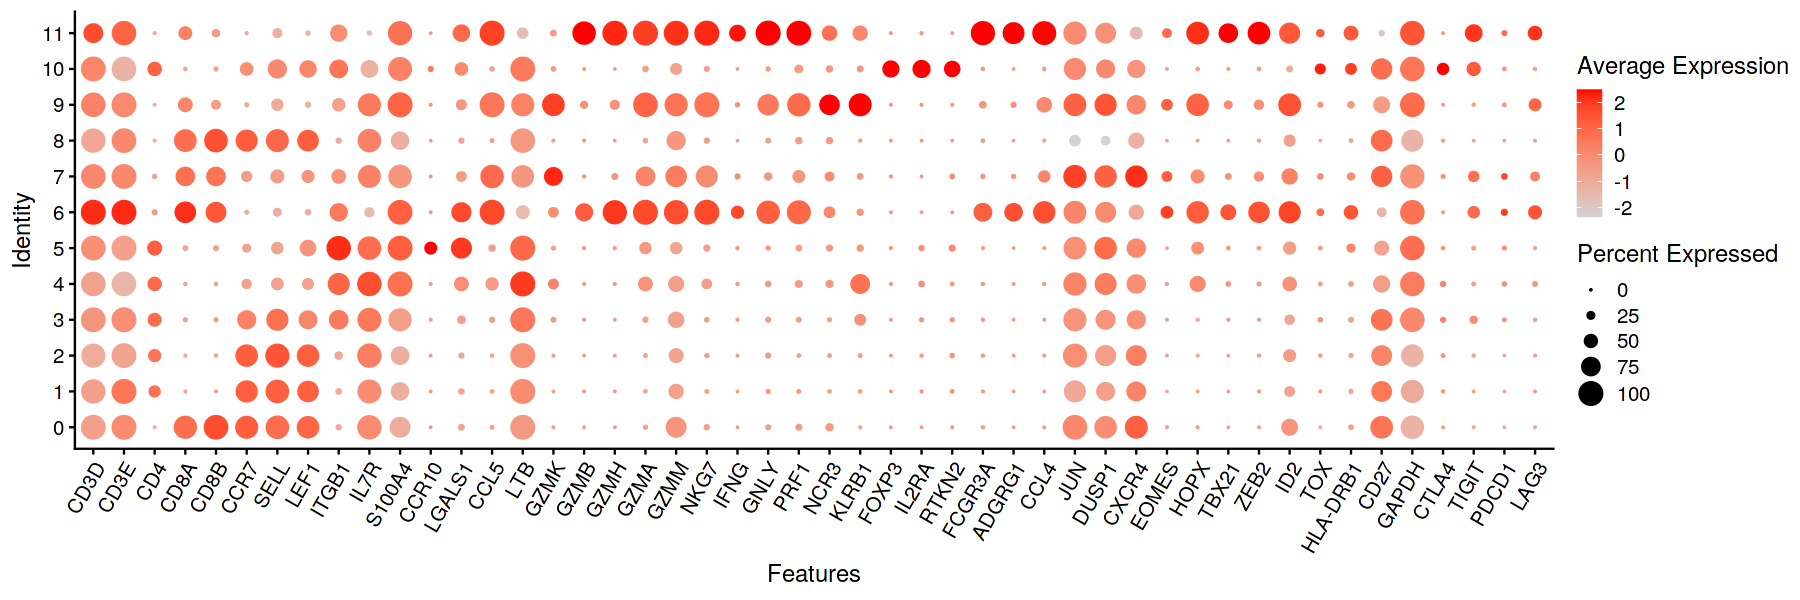

In [491]:
gene.list=c(
    "CD3D","CD3E",
    "CD4",         #cd4: 1,2,3,4,5,  11
    "CD8A","CD8B", #CD8: 0,9,  6,8,10,12
    
    "CCR7","SELL","LEF1",'ITGB1',"IL7R", "S100A4", # naive, mature
    "CCR10","LGALS1", #5
    "CCL5",#4 "KLRB1","GZMK", 
    
    "LTB", "GZMK","GZMB","GZMH","GZMA","GZMM", "NKG7", "IFNG","GNLY","PRF1", # toxic
    
     "NCR3","KLRB1",  #10 "IL7R",
    "FOXP3", "IL2RA", "RTKN2", # c11: CD4 Treg
    "FCGR3A",   #"NCAM1",  "NCR1", too low
    "ADGRG1", "CCL4", #12

     "JUN","DUSP1","CXCR4", #0 vs 9 "FOS","FOSB","JUNB", TF
    "EOMES","HOPX","TBX21", "ZEB2","ID2","TOX",# "ZNF683","HIF1A",
    
    "HLA-DRB1", "CD27",
    "GAPDH", # too low: "LAYN", "TNFRSF9",

    "CTLA4","TIGIT","PDCD1","LAG3" #,inhibitory
)
p1=DotPlot(sub_T, features = rev(unique( gene.list )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=15, repr.plot.height=5)
p1

ggsave(file=paste0(outputRoot,"02_dotPlot_manualMarker.pdf"), p1, width=15, height=5 )

In [493]:
head(sub_T@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters,cellType,RNA_snn_res.0.9,RNA_snn_res.1
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
AAACCCAGTCGGTGAA,pbmc10k,6590,1867,10.303490,13,9,CD8-KLRB1,9,9
AAACCCATCAGACAAA,pbmc10k,11543,2850,6.688036,2,0,Naive CD8-0,0,0
AAACCCATCCATACTT,pbmc10k,6686,2370,9.856416,4,6,CD8-FGFBP2,5,6
AAACGAACAACTCGAT,pbmc10k,5453,1480,11.424904,2,8,Naive CD8-8,8,8
AAACGAACACCGAATT,pbmc10k,10146,2406,3.617189,1,2,Naive CD4-2,3,2
AAACGAACAGACACCC,pbmc10k,8703,2369,3.171320,3,3,Naive CD4-3,4,3


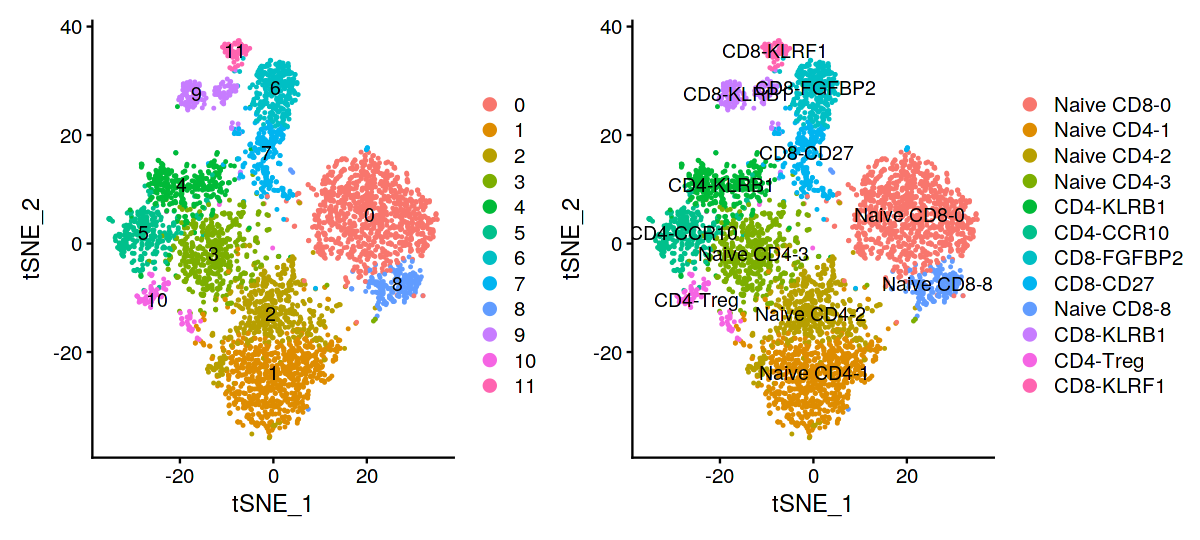

In [497]:
options(repr.plot.width=10, repr.plot.height=4.5)
p1=DimPlot(sub_T, reduction = 'tsne', label = T)
p2=DimPlot(sub_T, reduction = 'tsne', label = T, group.by = "cellType")
p1|p2

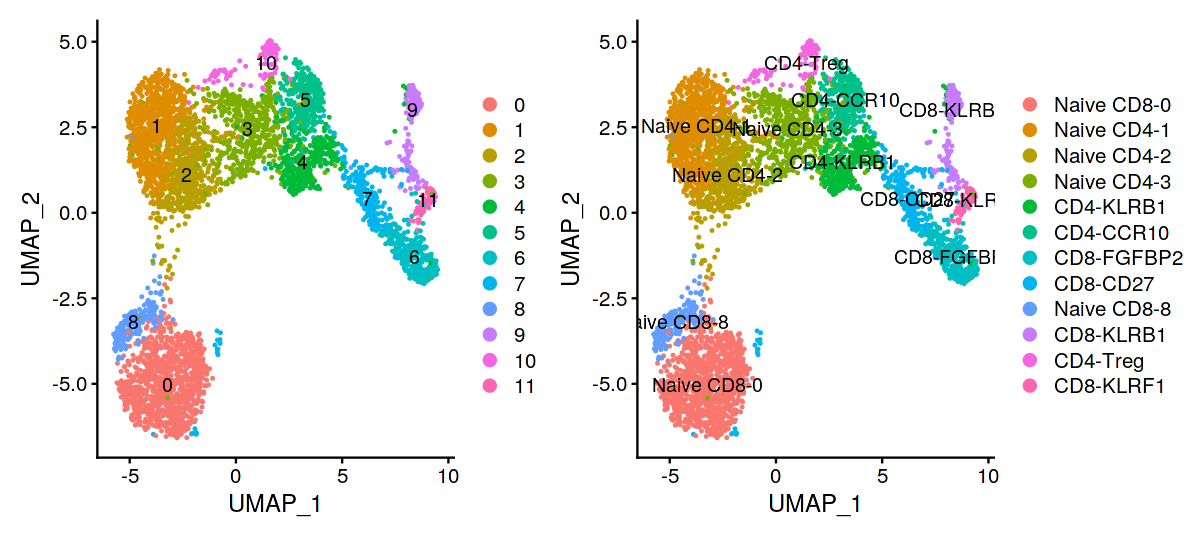

In [499]:
options(repr.plot.width=10, repr.plot.height=4.5)
p1=DimPlot(sub_T, reduction = 'umap', label = T)
p2=DimPlot(sub_T, reduction = 'umap', label = T, group.by = "cellType")
p1|p2

## 创建slingshot对象

In [500]:
# 2 min for 4600 cells
sds <- slingshot(Embeddings( sub_T, "umap"), clusterLabels = sub_T$seurat_clusters, 
                 # start.clus = 4, 
                 stretch = 0)

Using full covariance matrix

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning me

In [501]:
sds

class: SlingshotDataSet 

 Samples Dimensions
    4624          2

lineages: 6 
Lineage1: 0  8  2  3  4  7  9  
Lineage2: 0  8  2  3  4  7  6  
Lineage3: 0  8  2  3  4  7  11  
Lineage4: 0  8  2  3  5  
Lineage5: 0  8  2  3  10  
Lineage6: 0  8  2  1  

curves: 6 
Curve1: Length: 19.574	Samples: 2381.23
Curve2: Length: 20.993	Samples: 2698.72
Curve3: Length: 20.4	Samples: 2474.5
Curve4: Length: 19.795	Samples: 2388.87
Curve5: Length: 14.039	Samples: 1993
Curve6: Length: 10.808	Samples: 2193.26

In [510]:
summary(sds)

          Length            Class             Mode 
               1 SlingshotDataSet               S4 

## 添加颜色

In [502]:
seu=sub_T

Unfortunately, slingshot does not natively support ggplot2. So this is a function that assigns colors to each cell in base R graphics.

In [529]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
library(RColorBrewer)
library(scales)

cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) { # cluster number
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
      # cell type
    cell_vars=  as.character(cell_vars)
    categories <- sort(unique( cell_vars ))
    #pal <- setNames(pal_fun( length(categories), ...), categories)
      pal <- setNames( colorRampPalette( pal_fun(8) )(length(categories)) , categories)
    return(pal[cell_vars])
  }
}

In [530]:
# We need color palettes for both cell types and Leiden clusters. These would be the same colors seen in the Seurat plots.
cell_colors <- cell_pal(seu$cellType, brewer_pal("qual", "Set2")) # cell type
cell_colors_clust <- cell_pal(seu$seurat_clusters, hue_pal()) # cluster

In [531]:
head(cell_colors)
table(cell_colors)

CD8-KLRB1 Naive CD8-0  CD8-FGFBP2 Naive CD8-8 Naive CD4-2 Naive CD4-3 
  "#DB98AE"   "#D2BD9F"   "#BE93C6"   "#B3B3B3"   "#FCD738"   "#ECC978"

cell_colors
#66C2A5 #979EC1 #B1C968 #B3B3B3 #BE93C6 #C5A07A #CED843 #D2BD9F #DB98AE #DD927E 
    304     233      82     196     304     347     784    1052     174     103 
#ECC978 #FCD738 
    501     544 

In [532]:
head(cell_colors_clust)
table(cell_colors_clust)

9         0         6         8         2         3 
"#FF61CC" "#F8766D" "#12A4FF" "#DB72EC" "#38B638" "#00BE77"

cell_colors_clust
#00B4DE #00BE77 #00BEB3 #12A4FF #38B638 #83AB00 #9088FF #B69C00 #DB72EC #DC8A27 
    304     501     347     304     544      82     233     103     196     784 
#F8766D #FF61CC 
   1052     174 

## 可视化

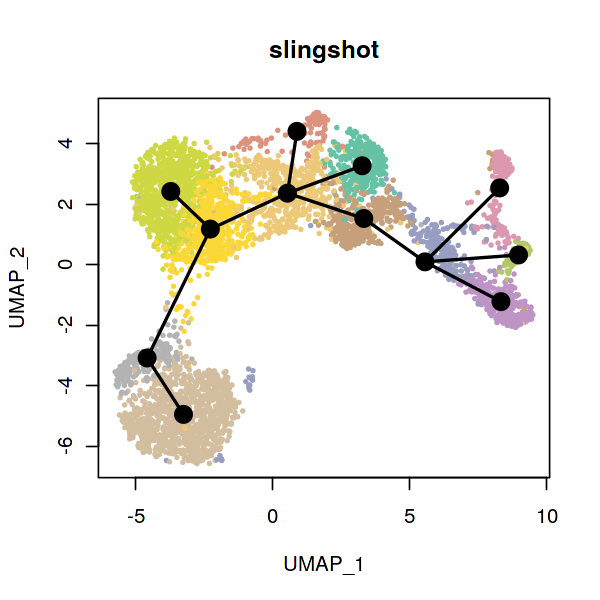

In [533]:
options(repr.plot.width=5, repr.plot.height=5)

plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5, main="slingshot")
lines(sds, lwd = 2, type = 'lineages', col = 'black')

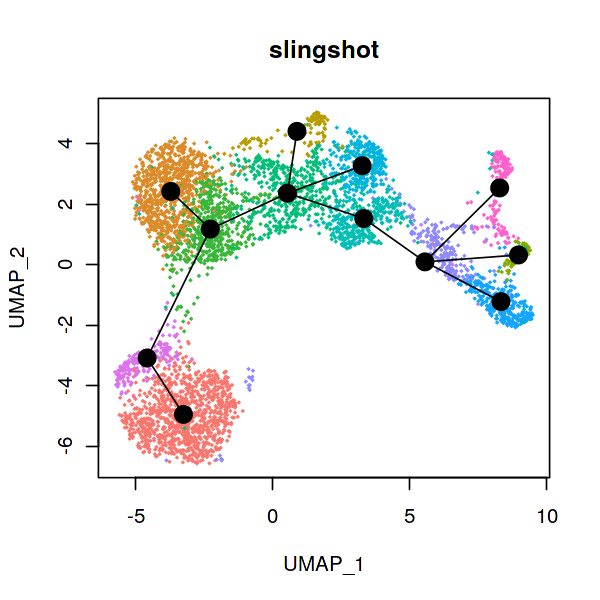

In [534]:
# See how this looks with Leiden clusters.
plot( reducedDim(sds), col = cell_colors_clust, pch = 18, cex = 0.5, main="slingshot")
lines(sds, lwd = 1, type = 'lineages', col = 'black')

### 平滑化

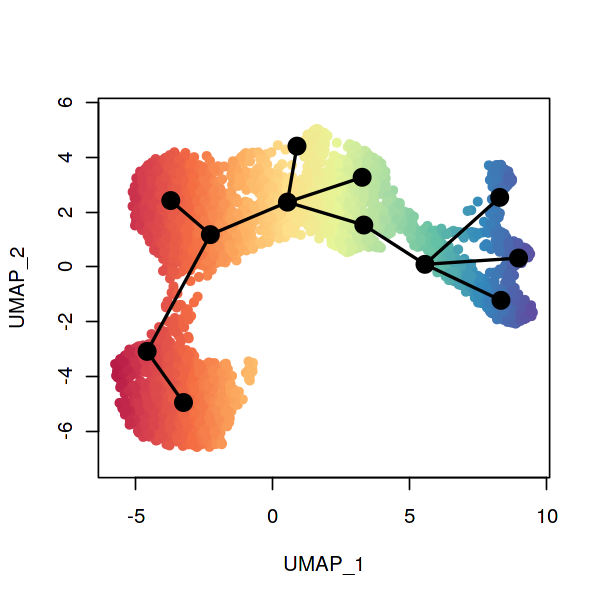

In [535]:
# 平滑化颜色
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100) #产生100个连续的颜色
plotcol <- colors[cut(sds@reducedDim, breaks=100)]

plot(reducedDims(sds), col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sds), lwd=2, col='black',type = 'lineages')

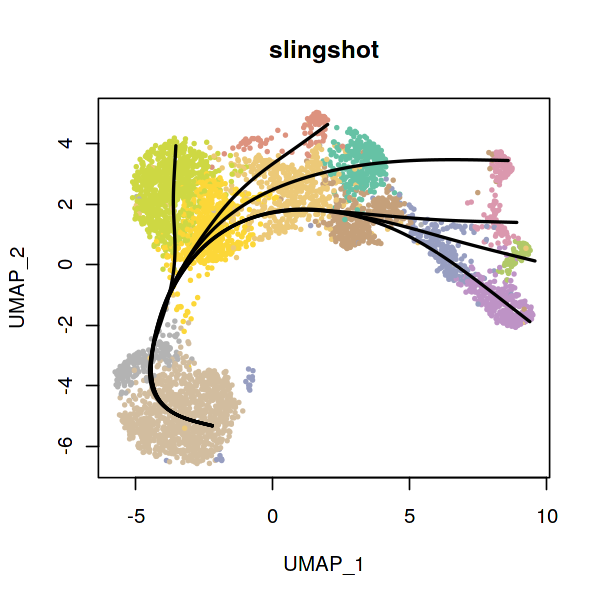

In [536]:
# 平滑化线条
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5, main="slingshot")
lines(sds, lwd = 2, col = 'black')

## UMAP

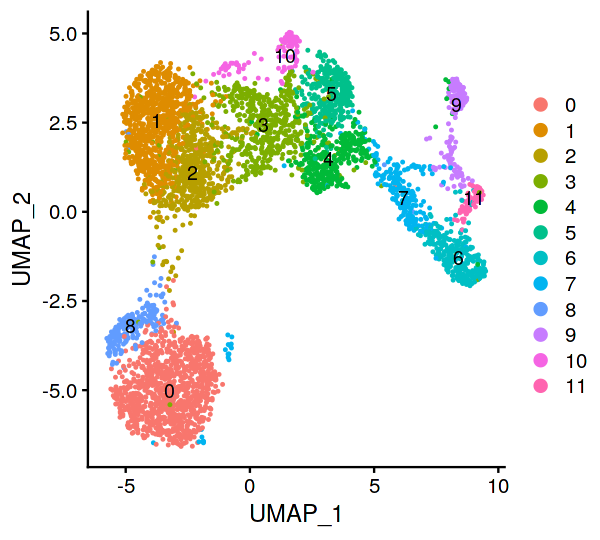

In [537]:
# UMAP plot
options(repr.plot.width=5, repr.plot.height=4.5)
DimPlot(sub_T, reduction = 'umap', label = T)

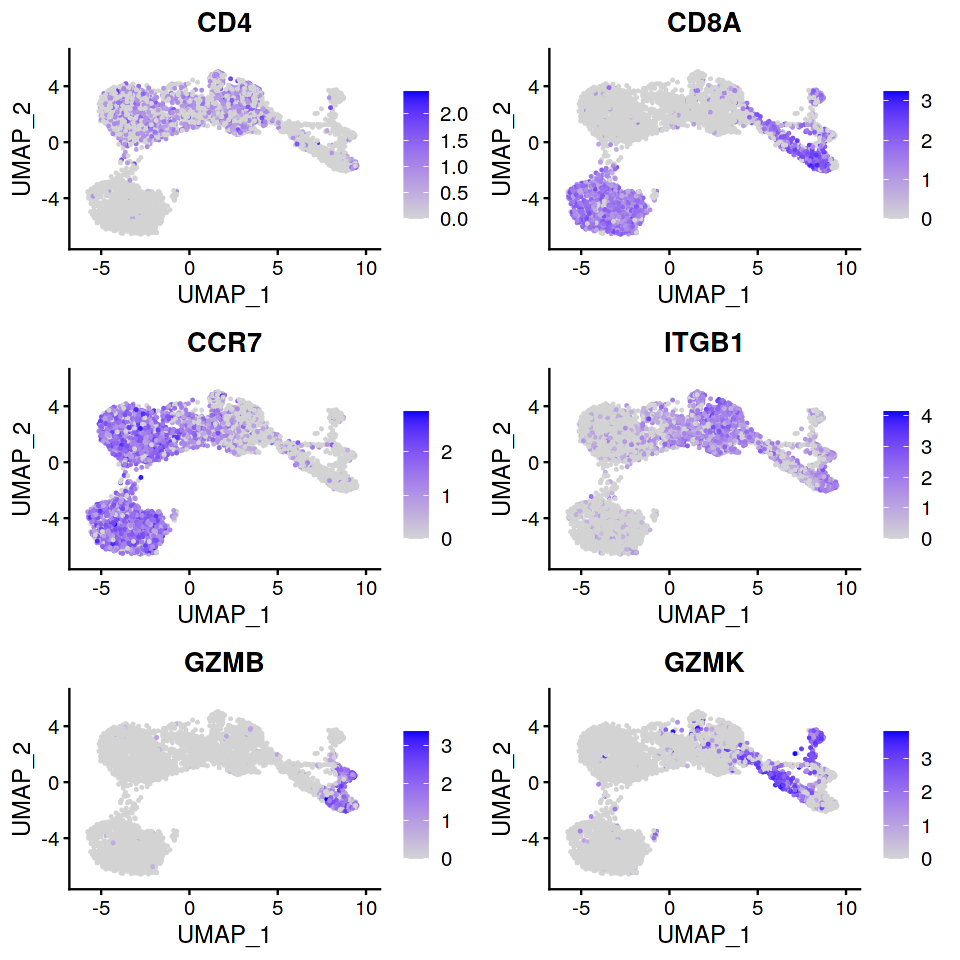

In [538]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(sub_T, reduction = 'umap', features = c("CD4","CD8A", "CCR7", 'ITGB1', "GZMB", "GZMK"))

In [539]:
sds

class: SlingshotDataSet 

 Samples Dimensions
    4624          2

lineages: 6 
Lineage1: 0  8  2  3  4  7  9  
Lineage2: 0  8  2  3  4  7  6  
Lineage3: 0  8  2  3  4  7  11  
Lineage4: 0  8  2  3  5  
Lineage5: 0  8  2  3  10  
Lineage6: 0  8  2  1  

curves: 6 
Curve1: Length: 19.574	Samples: 2381.23
Curve2: Length: 20.993	Samples: 2698.72
Curve3: Length: 20.4	Samples: 2474.5
Curve4: Length: 19.795	Samples: 2388.87
Curve5: Length: 14.039	Samples: 1993
Curve6: Length: 10.808	Samples: 2193.26

In [540]:
str(sds)

Formal class 'SlingshotDataSet' [package "slingshot"] with 6 slots
  ..@ reducedDim   : num [1:4624, 1:2] 8 -1.7 8.83 -4.13 -2.75 ...
  .. ..- attr(*, "scaled:center")= num [1:2] -3.48 -0.924
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:4624] "AAACCCAGTCGGTGAA" "AAACCCATCAGACAAA" "AAACCCATCCATACTT" "AAACGAACAACTCGAT" ...
  .. .. ..$ : chr [1:2] "UMAP_1" "UMAP_2"
  ..@ clusterLabels: num [1:4624, 1:12] 1 0 0 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:4624] "AAACCCAGTCGGTGAA" "AAACCCATCAGACAAA" "AAACCCATCCATACTT" "AAACGAACAACTCGAT" ...
  .. .. ..$ : chr [1:12] "9" "0" "6" "8" ...
  ..@ lineages     :List of 6
  .. ..$ Lineage1: chr [1:7] "0" "8" "2" "3" ...
  .. ..$ Lineage2: chr [1:7] "0" "8" "2" "3" ...
  .. ..$ Lineage3: chr [1:7] "0" "8" "2" "3" ...
  .. ..$ Lineage4: chr [1:5] "0" "8" "2" "3" ...
  .. ..$ Lineage5: chr [1:5] "0" "8" "2" "3" ...
  .. ..$ Lineage6: chr [1:4] "0" "8" "2" "1"
  ..@ adjacency    : num [1:12, 1:12] 0 0 0 0

## save RDS

In [541]:
saveRDS(sds, paste0(outputRoot, "_slingshot_PBMC_T_final.rds"))